In [2]:
import numpy as np
import sys
import h5py

class NeuralNetMLP(object):
    def __init__(self, n_hidden = 30, l2 = 0., epochs =100,
                 eta = 0.001, shuffle = True, minibatch_size = 1, seed = None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    def _onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
           onehot[val, idx] = 1
        return onehot.T
    
    def _sigmoid(self, z):
        return 1./(1. + np.exp(-np.clip(z, -250, 250)))
    
    def _forward(self, X):
        z_h = np.dot(X, self.w_h) + self.b_h
        a_h = self._sigmoid(z_h)
        z_out = np.dot(a_h, self.w_out) + self.b_out
        a_out = self._sigmoid(z_out)
        return z_h, a_h, z_out, a_out
    
    def _cost(self, y_enc, out_put):
        L2_term = self.l2 * (np.sum(self.w_h ** 2.) +  np.sum(self.w_out ** 2.))
        x1  = -y_enc * np.log(out_put)
        x2 = (1-y_enc) * np.log(1 - out_put)
        return np.sum(x1 - x2) + L2_term
    
    def predict(self, X):
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis = 1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]
        
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc = 0, scale = 0.1, size = (n_features, self.n_hidden))
        
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc = 0, scale = 0.1, size = (self.n_hidden, n_output))
        
        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost':[], 'train_accuracy':[], 'valid_accuracy': []}
        y_train_enc = self._onehot(y_train, n_output)
        
        for i in range(self.epochs):
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(indices)
                
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx : start_idx + self.minibatch_size]
                z_h, a_h, z_out, a_out  = self._forward(X_train[batch_idx])
                y_pred = self.predict(X_train[batch_idx])
                
                delta_out = (a_out - y_train_enc[batch_idx])*a_out*(1-a_out)
                sigmoid_derivative = a_h * (1. - a_h)
                
                delta_h = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative)
                
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis = 0)
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis = 0)
                
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
            
            
            
            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._cost(y_train_enc, a_out)
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])
            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_accuracy'].append(train_acc)
            self.eval_['valid_accuracy'].append(valid_acc)
        return self
    


In [3]:
from keras.datasets import mnist
(train_X, y_train), (test_X, y_test) = mnist.load_data()

In [4]:
X_train = train_X.reshape((train_X.shape[0],train_X.shape[1]*train_X.shape[2]))
print(y_train)

[5 0 4 ... 5 6 8]


In [5]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=200, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

C:\Users\HungVo\AppData\Local\Temp\ipykernel_13412\3240436031.py:95: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
C:\Users\HungVo\AppData\Local\Temp\ipykernel_13412\3240436031.py:97: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc = ((np.sum(y_valid == y_valid_pred

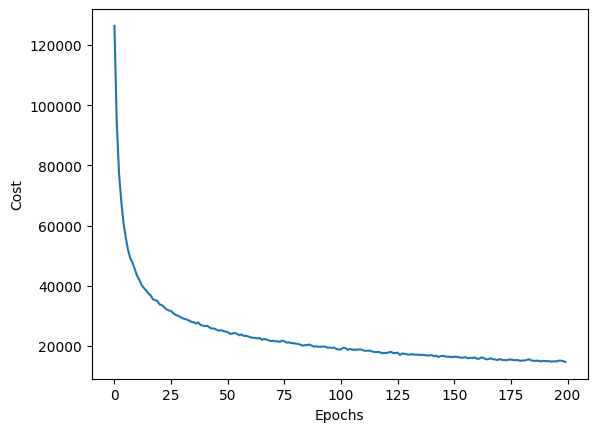

In [6]:
import matplotlib.pyplot as plt


plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

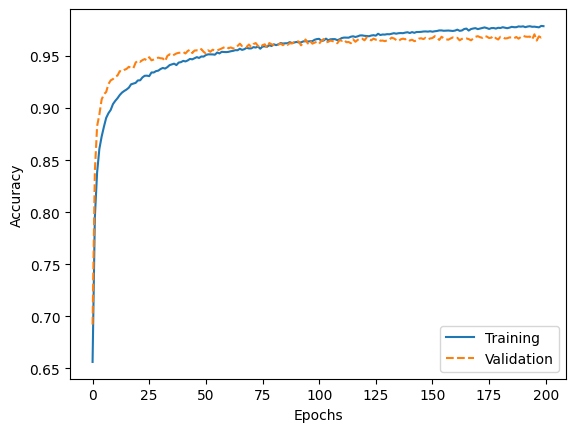

In [7]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['train_accuracy'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_accuracy'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [8]:
from sklearn.metrics import accuracy_score
X_test = test_X.reshape((test_X.shape[0],test_X.shape[1]*test_X.shape[2]))
y_pred_test = nn.predict(X_test)
print(accuracy_score(y_test,y_pred_test)*100)




95.83


In [9]:
X_train_new = np.concatenate((X_train, X_test), axis = 0)
y_train_new = np.concatenate((y_train, y_test), axis = 0)


nn.fit(X_train=X_train_new[:65000], 
       y_train=y_train_new[:65000],
       X_valid=X_train_new[65000:],
       y_valid=y_train_new[65000:])

C:\Users\HungVo\AppData\Local\Temp\ipykernel_13412\3240436031.py:95: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
C:\Users\HungVo\AppData\Local\Temp\ipykernel_13412\3240436031.py:97: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc = ((np.sum(y_valid == y_valid_pred

In [10]:
import joblib
  
  
# Save the model as a pickle in a file
joblib.dump(nn, 'Recognition.pkl')


['Recognition.pkl']